In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional


In [2]:
# loading Data set
stock_market = pd.read_excel('stock_market.xlsx')
# Viewing first 5 instances
stock_market.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
# Viewing characteristics of data
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2035 non-null   datetime64[ns]
 1   Open                  2035 non-null   float64       
 2   High                  2035 non-null   float64       
 3   Low                   2035 non-null   float64       
 4   Last                  2035 non-null   float64       
 5   Close                 2035 non-null   float64       
 6   Total Trade Quantity  2035 non-null   int64         
 7   Turnover (Lacs)       2035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 127.3 KB


In [4]:
# I will predicting just open and close features for particular dates 
# Subsetting and extracting only relevant features
stock_market = stock_market[['Date','Open','Close']] 
stock_market.set_index('Date',drop=True,inplace=True) 
stock_market.head()

,Open,Close
Date,,
2018-09-28,234.05,233.75
2018-09-27,234.55,233.25
2018-09-26,240.00,234.25
2018-09-25,233.30,236.10
2018-09-24,233.55,233.30


<AxesSubplot:xlabel='Date', ylabel='Open'>

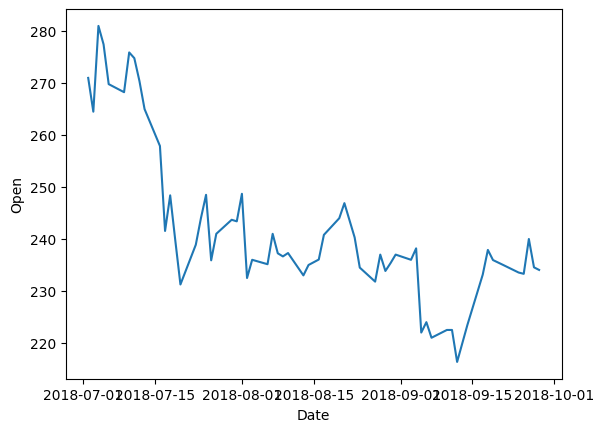

In [5]:
# Getting a graphical glance of date and open features
sns.lineplot(x='Date', y='Open', data=stock_market.iloc[:61])

<AxesSubplot:xlabel='Date', ylabel='Close'>

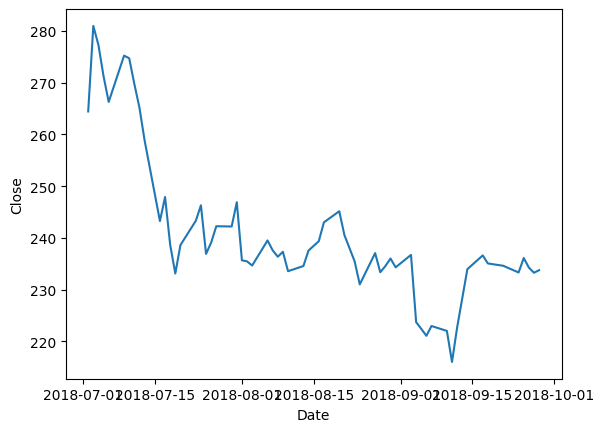

In [6]:
#  Getting a graphical glance of date and close features
sns.lineplot(x='Date', y='Close', data=stock_market.iloc[:61])

In [7]:
# Data preparation
min_max_scaler = MinMaxScaler()
stock_market[stock_market.columns] = min_max_scaler.fit_transform(stock_market)

In [8]:
stock_market.shape

(2035, 2)

In [9]:
train_size = round(len(stock_market)*.8)

In [10]:
X =stock_market[:train_size]
y =stock_market[train_size:]

In [11]:
X.shape, y.shape

((1628, 2), (407, 2))

In [12]:
X.head()

,Open,Close
Date,,
2018-09-28,0.620235,0.624183
2018-09-27,0.622263,0.622141
2018-09-26,0.644363,0.626225
2018-09-25,0.617194,0.633783
2018-09-24,0.618208,0.622345


In [13]:
# A function that takes a data set (X,y) and returns sequences of train and test parts
def create_sequence(dataset):
    sequences = []
    labels = []
    start_idx = 0

    for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
    return (np.array(sequences),np.array(labels))

In [14]:
train_seq, train_label = create_sequence(X)
test_seq, test_label = create_sequence(y)

In [15]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((1578, 50, 2), (1578, 2), (357, 50, 2), (357, 2))

In [16]:
# Building LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1)) 
model.add(LSTM(units=50))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
# Viewing model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [17]:
# training the model with my data set
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)


Epoch 1/80
50/50 [==============================] - 18s 153ms/step - loss: 0.0106 - mean_absolute_error: 0.0617 - val_loss: 5.0795e-04 - val_mean_absolute_error: 0.0179
Epoch 2/80
50/50 [==============================] - 5s 100ms/step - loss: 0.0012 - mean_absolute_error: 0.0246 - val_loss: 4.6548e-04 - val_mean_absolute_error: 0.0171
Epoch 3/80
50/50 [==============================] - 5s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0242 - val_loss: 4.5954e-04 - val_mean_absolute_error: 0.0169
Epoch 4/80
50/50 [==============================] - 5s 101ms/step - loss: 0.0011 - mean_absolute_error: 0.0240 - val_loss: 4.4244e-04 - val_mean_absolute_error: 0.0166
Epoch 5/80
50/50 [==============================] - 5s 103ms/step - loss: 0.0011 - mean_absolute_error: 0.0243 - val_loss: 4.0008e-04 - val_mean_absolute_error: 0.0158
Epoch 6/80
50/50 [==============================] - 6s 110ms/step - loss: 0.0010 - mean_absolute_error: 0.0229 - val_loss: 4.0044e-04 - val_mean_absolute_error

50/50 [==============================] - 5s 108ms/step - loss: 2.9080e-04 - mean_absolute_error: 0.0120 - val_loss: 1.6224e-04 - val_mean_absolute_error: 0.0102
Epoch 49/80
50/50 [==============================] - 5s 103ms/step - loss: 3.1600e-04 - mean_absolute_error: 0.0125 - val_loss: 1.1539e-04 - val_mean_absolute_error: 0.0084
Epoch 50/80
50/50 [==============================] - 5s 105ms/step - loss: 2.9184e-04 - mean_absolute_error: 0.0121 - val_loss: 1.2556e-04 - val_mean_absolute_error: 0.0086
Epoch 51/80
50/50 [==============================] - 5s 105ms/step - loss: 2.8340e-04 - mean_absolute_error: 0.0118 - val_loss: 1.5808e-04 - val_mean_absolute_error: 0.0102
Epoch 52/80
50/50 [==============================] - 5s 101ms/step - loss: 2.2901e-04 - mean_absolute_error: 0.0108 - val_loss: 1.1954e-04 - val_mean_absolute_error: 0.0086
Epoch 53/80
50/50 [==============================] - 5s 103ms/step - loss: 2.6478e-04 - mean_absolute_error: 0.0113 - val_loss: 1.3137e-04 - val_me

In [18]:
# Using model to predict with test data
test_predicted = model.predict(test_seq)
test_predicted[:5]

12/12 [==============================] - 3s 36ms/step


array([[0.03686212, 0.03395358],
       [0.04106053, 0.03820143],
       [0.0360221 , 0.033113  ],
       [0.03199546, 0.02900939],
       [0.02678745, 0.02367588]], dtype=float32)

In [19]:
test_inverse_predicted = min_max_scaler.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[90.1902  , 89.26183 ],
       [91.225525, 90.301704],
       [89.983055, 89.05606 ],
       [88.99008 , 88.05149 ],
       [87.70578 , 86.74586 ]], dtype=float32)

In [20]:
# merging actual open and close with predicted open and close
df = pd.concat([stock_market.iloc[-357:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=stock_market.iloc[-357:].index)], axis=1)

In [21]:
# Inverse scaling
df[['Open','Close']] = min_max_scaler.inverse_transform(df[['Open','Close']]) 

In [22]:
# Viewing few instances
df.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2011-12-23,90.9,88.70,90.190201,89.261833
2011-12-22,86.0,89.85,91.225525,90.301704
2011-12-21,87.0,86.35,89.983055,89.056061
2011-12-20,85.2,85.05,88.990082,88.051491
2011-12-19,86.1,84.50,87.705780,86.745857


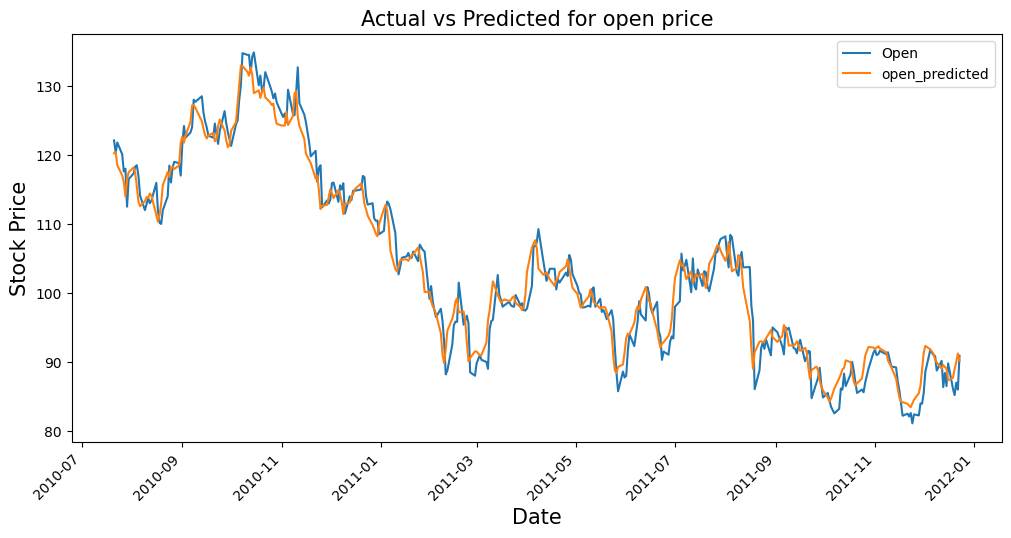

In [23]:
# Visualizing Open and predicted open
df[['Open','open_predicted']].plot(figsize=(12,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

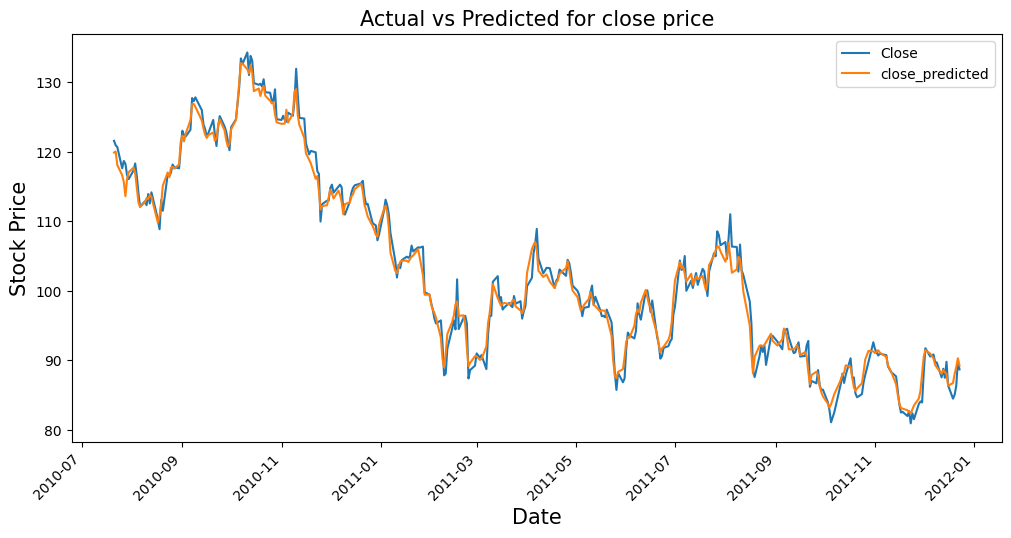

In [24]:
# Visualizing close and predicted close
df[['Close','close_predicted']].plot(figsize=(12,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()